In [230]:
import os, time, itertools
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.quantum_info import DensityMatrix
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
from operators.pauli_hamiltonian import PauliHamiltonian
from quantum_circuit.trotterization import trotter_electric, trotter_coupling, trotter_plaquette
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from utils.matrix_operations import *

In [2]:
# Initialize Simulator|
backend = Aer.get_backend('statevector_simulator')

In [6]:
sig = []
sig.append(np.eye(2))
sig.append(np.array([[0, 1], [1, 0]]))
sig.append(np.array([[0, -1j], [1j, 0]]))
sig.append(np.array([[1, 0], [0, -1]]))

In [341]:
def change_basis_measurement(circ, i, trg):
    if i == 1:
        circ.h(trg)
    elif i == 2:
        circ.rx(np.pi/2, trg)
        
def change_basis_input(circ, i, trg):
    if i == 0:
        circ.h(trg)
    elif i == 1:
        circ.ry(-np.pi/2, trg)
    elif i == 2:
        circ.rx(np.pi/2, trg)
    elif i == 3:
        circ.rx(-np.pi/2, trg)
    elif i == 5:
        circ.x(trg)

# 1-Qubit Tomography

## Measurement Simulations

In [339]:
def example_circ(circ):
    circ.ry(-np.pi/2, 0)

In [340]:
backend = Aer.get_backend('unitary_simulator')
cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
print(execute(circ, backend).result().get_unitary())

[[ 0.70710678+0.00000000e+00j  0.70710678+8.65956056e-17j]
 [-0.70710678+8.65956056e-17j  0.70710678+0.00000000e+00j]]


In [331]:
u = np.zeros((4))
u[0] = 1.0


backend = Aer.get_backend('qasm_simulator')

cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
circ.h(qr[0])
circ.measure(qr, cr)
job = execute(circ, backend, shots=1024)
u[1] =job.result().get_counts(circ).get('0', 0)/1024*(1)+job.result().get_counts(circ).get('1', 0)/1024*(-1)
print("<X> = ", u[1])

cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
circ.rx(np.pi/2, qr[0])
circ.measure(qr, cr)
job = execute(circ, backend, shots=1024)
u[2] =job.result().get_counts(circ).get('0', 0)/1024*(1)+job.result().get_counts(circ).get('1', 0)/1024*(-1)
print("<Y> = ", u[2])

cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
circ.measure(qr, cr)
job = execute(circ, backend, shots=1024)
u[3] =job.result().get_counts(circ).get('0', 0)/1024*(1)+job.result().get_counts(circ).get('1', 0)/1024*(-1)
print("<Z> = ", u[3])

<X> =  1.0
<Y> =  -0.0390625
<Z> =  -0.052734375


## Recover the Density Matrix $\rho$

In [6]:
rho = sum([sig[i]*u[i] for i in range(4)])/2
print(rho)

[[0.50683594+0.j         0.5       +0.01074219j]
 [0.5       -0.01074219j 0.49316406+0.j        ]]


## Exact Density Matrix

In [7]:
backend = Aer.get_backend('statevector_simulator')
cr = ClassicalRegister(1, 'cr')
qr = QuantumRegister(1, 'qr')
circ = QuantumCircuit(qr, cr)
example_circ(circ)
job = execute(circ, backend)
state = job.result().get_statevector(circ)
print(DensityMatrix(state).data)

[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


# Multi-qubit Tomography

In [102]:
def example_two_qubit_circ(circ, qr):
    circ.h(0)
    circ = trotter_coupling(circ, qr, [0, 1], 1.0, 1.0)
    return circ

## 2-qubit

In [185]:
u = np.zeros(4**2)
u[0] = 1.0
shots = 1024

backend = Aer.get_backend('qasm_simulator')
for itr, (i, j) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    # Due to the indexing convension of qiskit, i corresponds to 1-th qubit and j corresponds to 0-th qubit
    if i == 0 and j == 0:
        continue
    else:
        cr = ClassicalRegister(2, 'cr')
        qr = QuantumRegister(2, 'qr')
        circ = QuantumCircuit(qr, cr)
        circ = example_two_qubit_circ(circ, qr)
        if i == 0:
            # Measure only the 0-th qubit with the basis specified with j
            change_basis_measurement(circ, j, 0)
            circ.measure(qr[0], cr[0])
        else:
            if j == 0:
                # Measure only the 1-th qubit with the basis specified with i
                change_basis_measurement(circ, i, 1)
                circ.measure(qr[1], cr[1])
            else:
                # Measure both of the two qubits with the bases specified with i and j
                change_basis_measurement(circ, i, 1)
                change_basis_measurement(circ, j, 0)
                circ.measure(qr, cr)
        job = execute(circ, backend, shots=shots)
        u[itr] =job.result().get_counts(circ).get('00', 0)/shots*(1)+job.result().get_counts(circ).get('11', 0)/shots*(1) \
                        +job.result().get_counts(circ).get('01', 0)/shots*(-1)+job.result().get_counts(circ).get('10', 0)/shots*(-1)
print(u)

[ 1.          0.51953125 -0.03710938  0.73828125 -0.01757812  0.03515625
  0.4765625  -0.00390625 -0.84765625 -0.47265625  0.04101562 -0.81445312
  0.28320312  0.58007812 -0.00976562 -0.03125   ]


## Tomography

In [84]:
rho = sum([np.kron(sig[i], sig[j])*u[itr] for itr, (i, j) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)])])/2**2
print(rho)

[[ 5.03417969e-01+0.j          2.76367188e-01-0.00683594j
  -4.88281250e-03+0.42822266j -4.39453125e-03+0.00537109j]
 [ 2.76367188e-01+0.00683594j  1.26464844e-01+0.j
  -4.88281250e-04+0.21435547j  1.95312500e-03+0.00048828j]
 [-4.88281250e-03-0.42822266j -4.88281250e-04-0.21435547j
   3.74511719e-01+0.j         -1.17187500e-02+0.j        ]
 [-4.39453125e-03-0.00537109j  1.95312500e-03-0.00048828j
  -1.17187500e-02+0.j         -4.39453125e-03+0.j        ]]


## Exact Density Matrix

In [81]:
backend = Aer.get_backend('statevector_simulator')
cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
circ = example_two_qubit_circ(circ, qr)
job = execute(circ, backend)
state = job.result().get_statevector(circ)
print(DensityMatrix(state).data)

[[5.00000000e-01+0.j         2.70151153e-01+0.j
  2.57626187e-17+0.42073549j 0.00000000e+00+0.j        ]
 [2.70151153e-01+0.j         1.45963291e-01+0.j
  1.39196023e-17+0.22732436j 0.00000000e+00+0.j        ]
 [2.57626187e-17-0.42073549j 1.39196023e-17-0.22732436j
  3.54036709e-01+0.j         0.00000000e+00-0.j        ]
 [0.00000000e+00+0.j         0.00000000e+00+0.j
  0.00000000e+00+0.j         0.00000000e+00+0.j        ]]


## Compare

In [85]:
print(np.abs(DensityMatrix(state).data - rho))

[[0.00341797 0.00923954 0.00893865 0.00693978]
 [0.00923954 0.01949845 0.01297808 0.00201324]
 [0.00893865 0.01297808 0.02047501 0.01171875]
 [0.00693978 0.00201324 0.01171875 0.00439453]]


# Construct Noise Model Based on the Machine

In [94]:
# Load IBMQ account
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q-ornl', project='brookhaven')
print(provider.backends())
device_backend = provider.get_backend('ibmq_johannesburg')
coupling_map = device_backend.configuration().coupling_map
device_backend

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>]
[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>, <IBMQBackend('ibmq_burlington') from IBMQ(hub=

<IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>

In [96]:
# Construct the noise model from backend properties
noise_model = NoiseModel.from_backend(device_backend)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['cx', 'id', 'u2', 'measure', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('id', [5]), ('id', [6]), ('id', [7]), ('id', [8]), ('id', [9]), ('id', [10]), ('id', [11]), ('id', [12]), ('id', [13]), ('id', [14]), ('id', [15]), ('id', [16]), ('id', [17]), ('id', [18]), ('id', [19]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u2', [5]), ('u2', [6]), ('u2', [7]), ('u2', [8]), ('u2', [9]), ('u2', [10]), ('u2', [11]), ('u2', [12]), ('u2', [13]), ('u2', [14]), ('u2', [15]), ('u2', [16]), ('u2', [17]), ('u2', [18]), ('u2', [19]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('u3', [5]), ('u3', [6]), ('u3', [7]), ('u3', [8]), ('u3', [9]), ('u3', [10]), ('u3', [11]), ('u3', [12]), ('u3', [13]), ('u3', [14]), ('u3', [15]), ('u3', [16]),

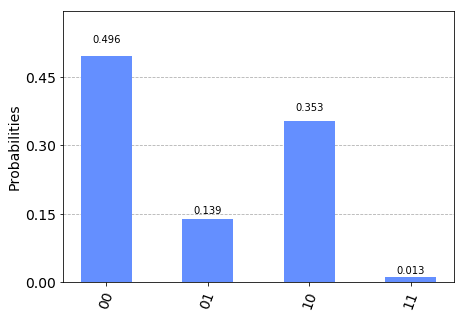

In [105]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Execute noisy simulation and get counts
backend = Aer.get_backend('qasm_simulator')
cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
circ = example_two_qubit_circ(circ, qr)
circ.measure(qr, cr)
result_noise = execute(circ, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts(circ)
plot_histogram(counts_noise)

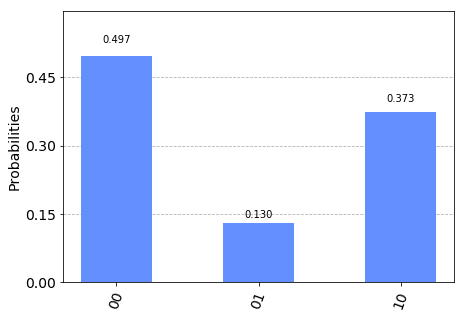

In [104]:
result_noise = execute(circ, backend).result()
counts_noise = result_noise.get_counts(circ)
plot_histogram(counts_noise)

Status @ 0 seconds
JobStatus.INITIALIZING
Status @ 30 seconds
JobStatus.QUEUED
Status @ 60 seconds
JobStatus.QUEUED
Status @ 90 seconds
JobStatus.QUEUED
Status @ 120 seconds
JobStatus.QUEUED
Status @ 150 seconds
JobStatus.QUEUED
Status @ 180 seconds
JobStatus.QUEUED
Status @ 210 seconds
JobStatus.QUEUED
Status @ 240 seconds
JobStatus.QUEUED
Status @ 270 seconds
JobStatus.QUEUED
Status @ 300 seconds
JobStatus.QUEUED
Status @ 330 seconds
JobStatus.QUEUED
Status @ 360 seconds
JobStatus.QUEUED
Status @ 390 seconds
JobStatus.QUEUED
Status @ 420 seconds
JobStatus.QUEUED
Status @ 450 seconds
JobStatus.QUEUED
Status @ 480 seconds
JobStatus.QUEUED
Status @ 510 seconds
JobStatus.QUEUED
Status @ 540 seconds
JobStatus.QUEUED
Status @ 570 seconds
JobStatus.QUEUED
Status @ 600 seconds
JobStatus.QUEUED
Status @ 630 seconds
JobStatus.RUNNING
Status @ 660 seconds
JobStatus.RUNNING
Status @ 690 seconds
JobStatus.RUNNING
JobStatus.DONE


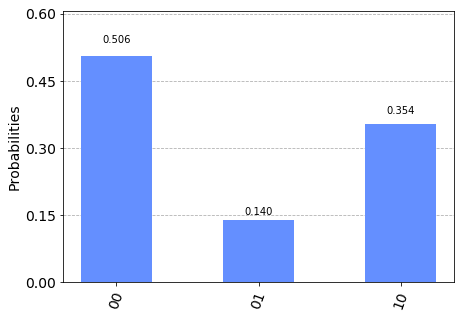

In [108]:
job = execute(circ, device_backend, shots=1024)
lapse = 0
interval = 30
while job.status() != JobStatus.DONE:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    time.sleep(interval)
    lapse += 1
print(job.status())
result_device = job_device.result()
counts_device = result_noise.get_counts(circ)
plot_histogram(counts_device)

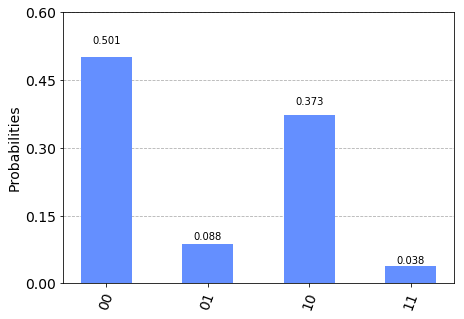

In [112]:
result_device = job.result()
counts_device = result_device.get_counts(circ)
plot_histogram(counts_device)

# Compute the matrix $S$

The matrix $S$ is equivalent to the expectation values of measurements of the exact output state $\Gamma_U(\rho)=U\rho U^\dagger$ in the Pauli basis.
\begin{align}
S_{i, k} = \langle\langle{k|R_{\Gamma_U}|\rho_i}\rangle\rangle = \langle\langle{k|U\rho_iU^\dagger}\rangle\rangle = Tr(P_k U\rho_iU^\dagger)
\end{align}

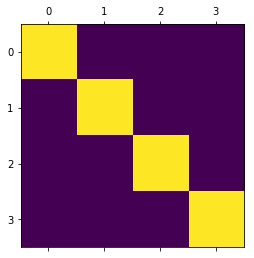

In [229]:
backend = Aer.get_backend('unitary_simulator')

cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
circ = trotter_electric(circ, qr, [0, 1], 1.0, 1.0, True)
job = execute(circ, backend)
U = job.result().get_unitary()
plt.matshow(np.abs(U))
plt.show()

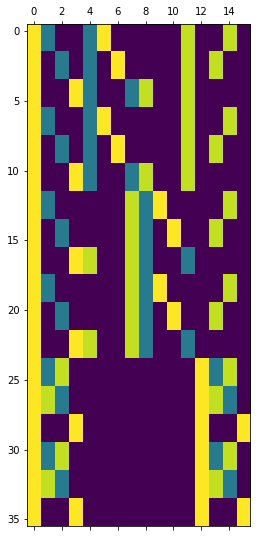

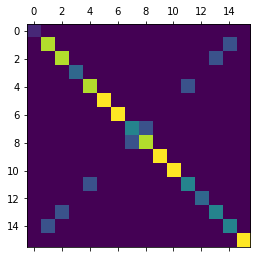

In [397]:
# Compute the 1-qubit states that are bases of X, Y, Z
ref1 = [
    np.array([1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex),
    np.array([1/np.sqrt(2), -1/np.sqrt(2)], dtype=complex),
    np.array([1/np.sqrt(2), 1j/np.sqrt(2)], dtype=complex),
    np.array([1/np.sqrt(2), -1j/np.sqrt(2)], dtype=complex),
    np.array([1, 0], dtype=complex),
    np.array([0, 1], dtype=complex)
]


# Compute the 2-qubit reference states
ref = []
for itr, (i, j) in enumerate([p for p in itertools.product(list(range(6)), repeat=2)]):
    state = np.kron(ref1[i], ref1[j])
    ref.append(np.outer(np.conjugate(state), state))

S = np.zeros((36, 16), complex)
for k, (k1, k2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    for i in range(36):
        S[i, k] = np.trace(matmul([np.kron(sig[k1], sig[k2]), U, ref[i], np.conjugate(U).T]))/np.sqrt(4)
plt.matshow(np.abs(S))
plt.show()
S_H = np.conjugate(S).T
SS = np.matmul(S_H, S)
SS_inv = np.linalg.inv(SS)
plt.matshow(np.abs(SS_inv))
plt.show()

## Compute the PTM of $\epsilon$
\begin{equation}
\langle\langle{k|R_\epsilon|l}\rangle\rangle = ((S^\dagger S)^{-1}S^\dagger P)^T_{k, l}
\end{equation}

In [381]:
def expectation(counts, shots):
    return counts.get('00', 0)/shots*(1)+counts.get('11', 0)/shots*(1) \
                    +counts.get('01', 0)/shots*(-1)+counts.get('10', 0)/shots*(-1)
noise_model = NoiseModel.from_backend(device_backend)
shots = 1024
backend = Aer.get_backend('qasm_simulator')
P_S = np.zeros((36, 16))
for i, (i1, i2) in enumerate([p for p in itertools.product(list(range(6)), repeat=2)]): 
    # the input state rho_i = |i1>|i2> where |i1>, |i2> \in {|0>, |1>, |+>, |->, |R>, |L>}
    for j, (j1, j2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
        if j == 0:
            P_S[i, j] = 1.0
            continue
        else:
            cr = ClassicalRegister(2, 'cr')
            qr = QuantumRegister(2, 'qr')
            circ = QuantumCircuit(qr, cr)
            change_basis_input(circ, i1, 1)
            change_basis_input(circ, i2, 0)
            circ = trotter_electric(circ, qr, [0, 1], 1.0, 1.0, False)
            if j1 == 0:
                # Measure only the 0-th  with the basis specified with j
                change_basis_measurement(circ, j2, 0)
                circ.measure(qr[0], cr[0])
            else:
                if j2 == 0:
                    # Measure only the 1-th qubit with the basis specified with i
                    change_basis_measurement(circ, j1, 1)
                    circ.measure(qr[1], cr[1])
                else:
                    # Measure both of the two qubits with the bases specified with i and j
                    change_basis_measurement(circ, j1, 1)
                    change_basis_measurement(circ, j2, 0)
                    circ.measure(qr, cr)
            job = execute(circ, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,
                       shots = shots)
            P_S[i, j] =expectation(job.result().get_counts(circ), shots)
    
P_S /= np.sqrt(4)
print(P_S)

[[ 0.5        -0.19433594  0.01660156  0.00878906 -0.16796875  0.40625
  -0.03808594 -0.00195312  0.00585938  0.01269531 -0.01269531  0.38183594
   0.02929688  0.01269531  0.39257812  0.01855469]
 [ 0.5         0.19628906 -0.00585938  0.02929688 -0.1875     -0.41015625
   0.01757812 -0.00097656  0.0234375   0.015625   -0.01171875  0.36816406
  -0.03125     0.02832031 -0.37890625  0.00488281]
 [ 0.5        -0.00488281  0.20410156  0.02929688 -0.203125   -0.01367188
  -0.41503906  0.00097656 -0.0078125   0.00683594 -0.00585938  0.37792969
   0.02441406  0.38867188  0.00292969  0.00195312]
 [ 0.5        -0.02246094 -0.19824219  0.01074219 -0.20117188  0.01074219
   0.40820312  0.0234375   0.00585938 -0.00585938  0.01367188  0.39648438
   0.01953125 -0.39160156  0.015625    0.02246094]
 [ 0.5         0.00976562  0.00878906  0.47167969 -0.17285156 -0.00390625
   0.02148438 -0.17285156  0.43066406  0.0078125   0.02539062  0.40625
   0.01074219  0.00683594  0.01269531  0.03808594]
 [ 0.5     

(1.0000000000000002+0j)


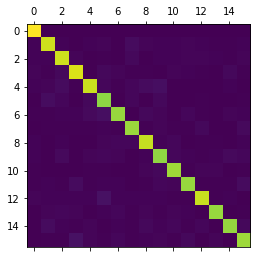

In [382]:
ptm_eps = matmul([SS_inv, S_H, P_S]).T
print(ptm_eps[0, 0])
plt.matshow(np.abs(ptm_eps))
plt.show()

## The inner product between Paulis and reference states 
\begin{align}
\langle\langle l|\rho_i \rangle\rangle = \frac{1}{\sqrt{d}}Tr(P_l \rho_i)
\end{align}
For the reference state $\rho_i$, which must be some physical states of at least 16, we choose $\{|0\rangle, |1\rangle, |+\rangle, |-\rangle, |R\rangle, |L\rangle\}^{\otimes 2}$.  

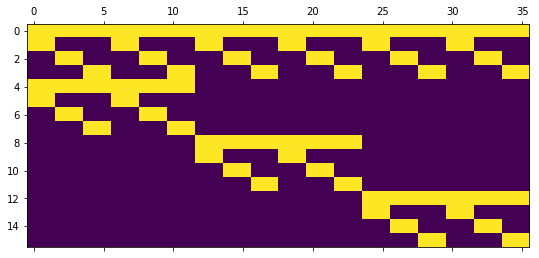

In [399]:
inn_mrho = np.zeros((16, 36), dtype=complex)
for l, (l1, l2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    for i in range(36):
        inn_mrho[l, i] = np.trace(np.matmul(np.kron(sig[l1], sig[l2]), ref[i]))/np.sqrt(4)
plt.matshow(np.abs(inn_mrho))
plt.show()

## Compute the matrix $T$
The matrix $T$ is given as 
\begin{align}
T_{i, k} = \sum_l \langle\langle{k|R_\epsilon|l}\rangle\rangle\langle\langle{l|\rho_i}\rangle\rangle
\end{align}

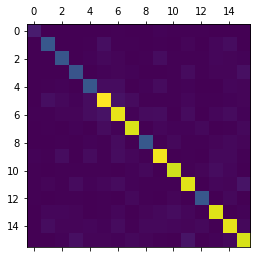

In [400]:
T = matmul([ptm_eps, inn_mrho]).T
T_H = np.conjugate(T).T
TT = np.matmul(T_H, T)
TT_inv = np.linalg.inv(TT)#+1e-12*np.eye(16))
plt.matshow(np.abs(TT_inv))
plt.show()

## Compute the PTM of $\epsilon^{-1}$
\begin{equation}
\langle\langle{j|R_{\epsilon^{-1}}|k}\rangle\rangle = ((T^\dagger T)^{-1}T^\dagger P)^T_{j, k}
\end{equation}

In [401]:
ptm_eps_inv = matmul([TT_inv, T_H, inn_mrho.T]).T
print(ptm_eps_inv)

[[ 1.00000000e+00-7.70371978e-34j  3.16587034e-17+8.36575820e-34j
  -8.84166872e-17-1.61296633e-33j  0.00000000e+00-1.19407657e-32j
   1.44849410e-16-2.37731978e-33j -3.80826013e-17-2.33519006e-33j
   4.51028104e-17-3.56297040e-33j  1.66370823e-16-1.85370757e-33j
  -4.27175656e-17+3.00926554e-33j  2.31585584e-16+6.07871639e-34j
   9.75781955e-18+4.45371300e-34j -8.32667268e-17-6.95742192e-33j
   5.55111512e-17+0.00000000e+00j  1.73472348e-17-2.14861559e-33j
  -1.31012280e-16-4.06852701e-33j -5.55111512e-17+1.77901760e-31j]
 [-1.21177552e-02-4.09686980e-21j  1.08357741e+00+3.27737194e-21j
  -1.40070781e-02-2.42951267e-21j  4.13408429e-03+7.59720976e-22j
  -9.93545877e-03-6.11572726e-21j -1.94542036e-02-1.38158053e-20j
  -2.81269578e-03-1.05912169e-20j -3.58470716e-02-5.68203627e-21j
   1.56805581e-02+8.71470927e-21j  1.38219872e-02+5.23189228e-21j
  -1.27454360e-02-2.59968018e-21j  1.91056389e-02-1.08345820e-20j
   9.65608163e-03+1.75332682e-19j -9.02269137e-03-8.48290689e-21j
   7.7898

## Compute the matrix $\Sigma = Tr[P_k P_i P_l P_j]$ to recover the process matrix from the PTM
One may recover the process matrix by
\begin{align}
\vec{\chi} = \Sigma^{-1}\vec{m}
\end{align}
where $\vec{\chi}_{i+j(d-1)} = \chi_{ij}$ and $\vec{m}_{k+l(d-1)} = \langle\langle k|R_{\epsilon^{-1}}|l \rangle\rangle$. 

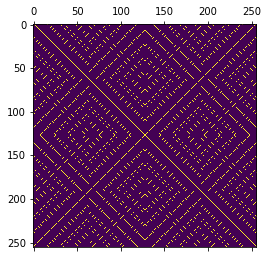

In [356]:
SigMat = np.zeros([256, 256], dtype=complex)
for itr1, (i1, i2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    for itr2, (j1, j2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
        for itr3, (k1, k2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
            for itr4, (l1, l2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
                P_i = np.kron(sig[i1], sig[i2])
                P_j = np.kron(sig[j1], sig[j2])
                P_k = np.kron(sig[k1], sig[k2])
                P_l = np.kron(sig[l1], sig[l2])
                SigMat[itr1+itr2*16, itr3+itr4*16] = np.trace(np.matmul(P_k, np.matmul(P_i, np.matmul(P_l, P_j))))/4
plt.matshow(np.abs(SigMat))
plt.show()

(0.9999999999999994-7.583349156024741e-34j)


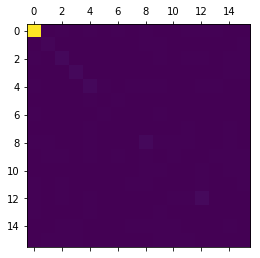

In [402]:
ptm_eps_inv_vec = np.reshape(ptm_eps_inv, [-1, 1])
chi_eps_inv_vec = np.dot(np.linalg.inv(SigMat), ptm_eps_inv_vec)
chi_eps_inv = np.reshape(chi_eps_inv_vec, [16, 16])
print(np.trace(chi_eps_inv))
plt.matshow(np.abs(chi_eps_inv))
plt.show()

(1-2.407412430484045e-35j)


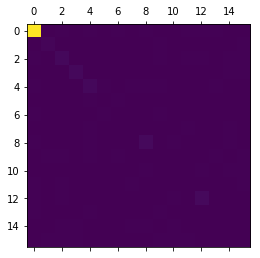

In [403]:
ptm_eps_vec = np.reshape(ptm_eps, [-1, 1])
chi_eps_vec = np.dot(np.linalg.inv(SigMat), ptm_eps_vec)
chi_eps = np.reshape(chi_eps_vec, [16, 16])
print(np.trace(chi_eps))
plt.matshow(np.abs(chi_eps))
plt.show()

## Check if $\chi_{\epsilon^{-1}}$ is correct

In [225]:
backend = Aer.get_backend('statevector_simulator')
cr = ClassicalRegister(2, 'cr')
qr = QuantumRegister(2, 'qr')
circ = QuantumCircuit(qr, cr)
circ = trotter_electric(circ, qr, [0, 1], 1.0, 1.0, True)
job = execute(circ, backend)
state = job.result().get_statevector(circ)
exact_rho = DensityMatrix(state).data
print(exact_rho)

[[1.+0.j 0.-0.j 0.-0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


## Tomography the noisy output state

In [404]:
u = np.zeros(4**2)
u[0] = 1.0
shots = 1024

backend = Aer.get_backend('qasm_simulator')
for itr, (i, j) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    # Due to the indexing convension of qiskit, i corresponds to 1-th qubit and j corresponds to 0-th qubit
    if i == 0 and j == 0:
        continue
    else:
        cr = ClassicalRegister(2, 'cr')
        qr = QuantumRegister(2, 'qr')
        circ = QuantumCircuit(qr, cr)
        circ = trotter_electric(circ, qr, [0, 1], 1.0, 1.0, True)
        if i == 0:
            # Measure only the 0-th qubit with the basis specified with j
            change_basis_measurement(circ, j, 0)
            circ.measure(qr[0], cr[0])
        else:
            if j == 0:
                # Measure only the 1-th qubit with the basis specified with i
                change_basis_measurement(circ, i, 1)
                circ.measure(qr[1], cr[1])
            else:
                # Measure both of the two qubits with the bases specified with i and j
                change_basis_measurement(circ, i, 1)
                change_basis_measurement(circ, j, 0)
                circ.measure(qr, cr)
        job = execute(circ, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,
                       shots = shots)
        u[itr] =job.result().get_counts(circ).get('00', 0)/shots*(1)+job.result().get_counts(circ).get('11', 0)/shots*(1) \
                        +job.result().get_counts(circ).get('01', 0)/shots*(-1)+job.result().get_counts(circ).get('10', 0)/shots*(-1)
noisy_rho = sum([np.kron(sig[i], sig[j])*u[itr] for itr, (i, j) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)])])/2**2
print(noisy_rho)

[[ 0.94042969+0.j         -0.00634766+0.01806641j  0.03271484+0.01464844j
  -0.00732422+0.00341797j]
 [-0.00634766-0.01806641j  0.01757812+0.j          0.00830078+0.01318359j
   0.00341797-0.00195312j]
 [ 0.03271484-0.01464844j  0.00830078-0.01318359j  0.04199219+0.j
   0.00537109+0.00634766j]
 [-0.00732422-0.00341797j  0.00341797+0.00195312j  0.00537109-0.00634766j
   0.        +0.j        ]]


[[ 0.99295525+2.82243777e-17j -0.00898975+2.11025363e-02j
   0.02994127+1.60070041e-02j -0.01295919+1.23577383e-02j]
 [-0.00898975-2.11025363e-02j -0.01319824+5.63448634e-18j
  -0.00464832+8.68234453e-03j  0.00641393-1.60284728e-02j]
 [ 0.02994127-1.60070041e-02j -0.00464832-8.68234453e-03j
  -0.02420337+7.98249386e-18j  0.01113662+1.48574011e-02j]
 [-0.01295919-1.23577383e-02j  0.00641393+1.60284728e-02j
   0.01113662-1.48574011e-02j  0.01255658-1.53143557e-17j]]


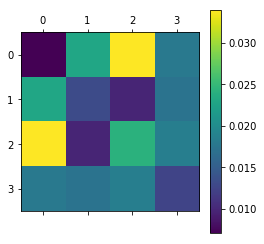

In [406]:
mitigated_rho = np.zeros((4, 4), dtype=complex)
for i, (i1, i2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
    for j, (j1, j2) in enumerate([p for p in itertools.product(list(range(4)), repeat=2)]):
        mitigated_rho += chi_eps_inv[i, j]*np.matmul(np.matmul(np.kron(sig[i1], sig[i2]), noisy_rho), np.kron(sig[j1], sig[j2]))
        
print(mitigated_rho)
plt.matshow(np.abs(mitigated_rho-exact_rho))
plt.colorbar()
plt.show()